In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from copy import deepcopy
import itertools
import json
from pathlib import Path
import pickle

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from tqdm import tqdm, trange, tqdm_notebook as tqdmn

from BEKML import BEMKL, plot_distplot
from utils import poly_kernel, gauss_kernel, scoring, plot_kernel_importances, plot_compare_models

sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/pml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
datasets = {
    fname.stem.replace('proc_', ''): pd.read_csv(fname)
    for fname in Path('data/').glob('proc_*.csv')
}
datasets_df = pd.DataFrame([(ds_name, *dataset.shape)for ds_name, dataset in datasets.items()],
                           columns=['name', 'samples', 'features'])

In [3]:
cwd = Path('.').resolve()

results = []
for f in cwd.glob('*_results.json'):
    with f.open() as fp:
        results.append((f.stem, json.load(fp)))

len(results), results[0]

(6,
 ('breast_results',
  {'base': {'kernels': [130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130],
    'scores': [0.8830409356725146,
     0.8304093567251462,
     0.9005847953216374,
     0.8588235294117647,
     0.8654970760233918,
     0.8947368421052632,
     0.9181286549707602,
     0.8294117647058824,
     0.9181286549707602,
     0.8596491228070176,
     0.8596491228070176,
     0.8647058823529412,
     0.8947368421052632,
     0.8362573099415205,
     0.9239766081871345,
     0.8235294117647058,
     0.8888888888888888,
     0.8771929824561403,
     0.8713450292397661,
     0.8705882352941177],
    'svs': [465,
     452,
     463,
     439,
     417,
     482,
     473,
     458,
     433,
     448,
     468,
     454,
     488,
     457,
     445,
     487,
     455,
     496,
     457,
     492],
    'times': [10.345966339111328,
   

In [4]:
df = pd.DataFrame()
model_type = {
    'base': 'dense',
    'ksparse': 'kernel_sparse',
    'ssparse': 'sv_sparse',
}
for exp_name, result in results:
    exp_name = exp_name.replace('_results', '')
    for key, val in result.items():
        if key in ('total_kernels', 'total_sv'):
            continue
        df_res = pd.DataFrame()
        df_res['kernel_nr'] = val['kernels']
        df_res['acc_score'] = val['scores']
        df_res['sv_nr'] = val['svs']
        df_res['train_time'] = val['times']
        df_res['total_kernels'] = result['total_kernels']
        df_res['total_sv'] = result['total_sv']
        df_res['model_type'] = model_type[key]
        df_res['experiment'] = exp_name
        df_res['kernel_frac'] = df_res['kernel_nr']/df_res['total_kernels']
        df_res['sv_frac'] = df_res['sv_nr']
        df_res['sv_frac'] /= int(datasets_df.loc[datasets_df.name==exp_name, 'samples'].iloc[0] * 0.75)
        df = df.append(df_res)
df.sample(10)

,kernel_nr,acc_score,sv_nr,train_time,total_kernels,total_sv,model_type,experiment,kernel_frac,sv_frac
9,3,0.755102,127,7.605986,442,135,kernel_sparse,wpbc,0.006787,0.875862
19,130,0.870588,492,10.063197,130,478,dense,breast,1.000000,0.960938
10,38,0.877193,475,10.857205,130,478,kernel_sparse,breast,0.292308,0.927734
8,190,0.792453,151,20.095862,780,145,dense,sonar,0.243590,0.967949
19,13,0.686275,150,19.166006,780,145,dense,sonar,0.016667,0.961538
4,13,0.937063,406,20.353114,403,398,dense,wdbc,0.032258,0.953052
4,13,0.849057,30,19.688817,780,145,sv_sparse,sonar,0.016667,0.192308
6,117,0.656250,548,11.365778,117,537,dense,pima,1.000000,0.951389
16,455,0.865169,254,11.653336,455,245,dense,ionosphere,1.000000,0.965779
9,12,0.687500,514,11.247626,117,537,kernel_sparse,pima,0.102564,0.892361


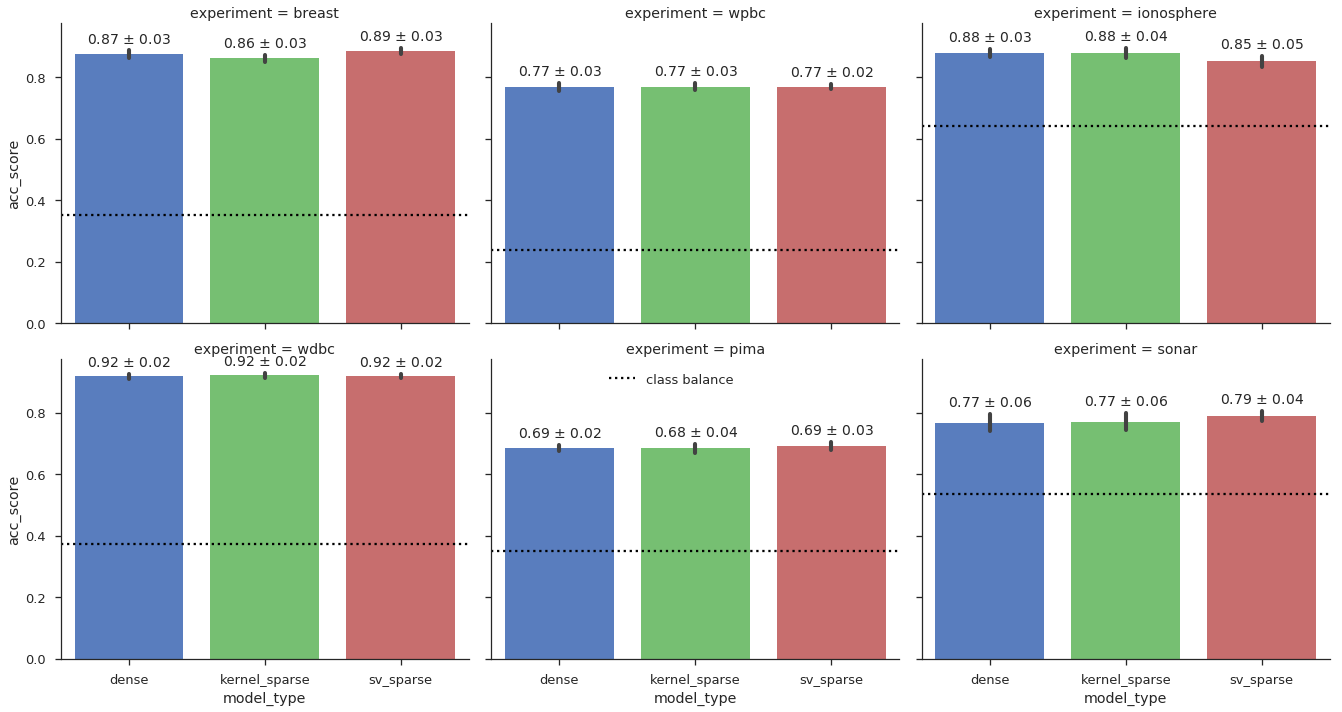

In [5]:
grid = sns.factorplot(x="model_type", y="acc_score", col="experiment", data=df,
                      size=5, aspect=1.25, kind="bar", col_wrap=3, palette="muted");

for ax, exp_name, (_, data) in zip(grid.axes, grid.col_names, grid.facet_data()):
    y = datasets[exp_name].iloc[:, -1]
    mean_pos = (y == 1).mean()
    ax.axhline(mean_pos, color='k', ls=':', label='class balance')

    for (group_name, group), l in zip(data.groupby('model_type'), ax.get_lines()):
        xy_data = l.get_xydata()[1]
        ax.annotate(f"{group.acc_score.mean():0.2f} $\pm$ {group.acc_score.std():0.2f}",
                     (xy_data[0] - 0.305, xy_data[1] + 0.025),
                     xycoords='data', size=14)
grid.fig.legend(loc=(0.45, 0.45));

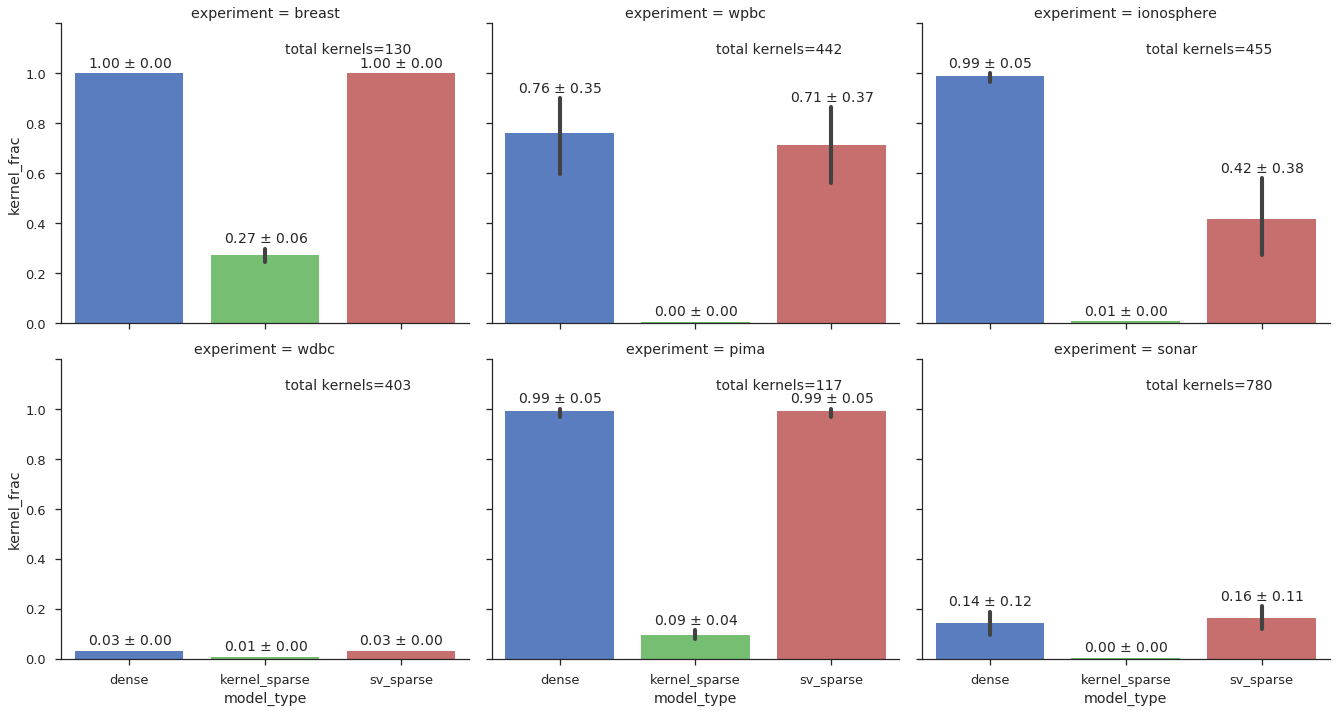

In [6]:
grid = sns.factorplot(x="model_type", y="kernel_frac", col="experiment", data=df,
                      size=5, aspect=1.25, kind="bar", col_wrap=3, palette="muted")
for ax, (_, data) in zip(grid.axes, grid.facet_data()):
    ax.annotate(f"total kernels={data.total_kernels.values[0]}", (0.55, 0.9), xycoords='axes fraction', size=14)
    ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
    ax.set_ylim(0, 1.2)

    for (group_name, group), l in zip(data.groupby('model_type'), ax.get_lines()):
        xy_data = l.get_xydata()[1]
        ax.annotate(f"{group.kernel_frac.mean():0.2f} $\pm$ {group.kernel_frac.std():0.2f}",
                     (xy_data[0] - 0.305, xy_data[1] + 0.025),
                     xycoords='data', size=14)

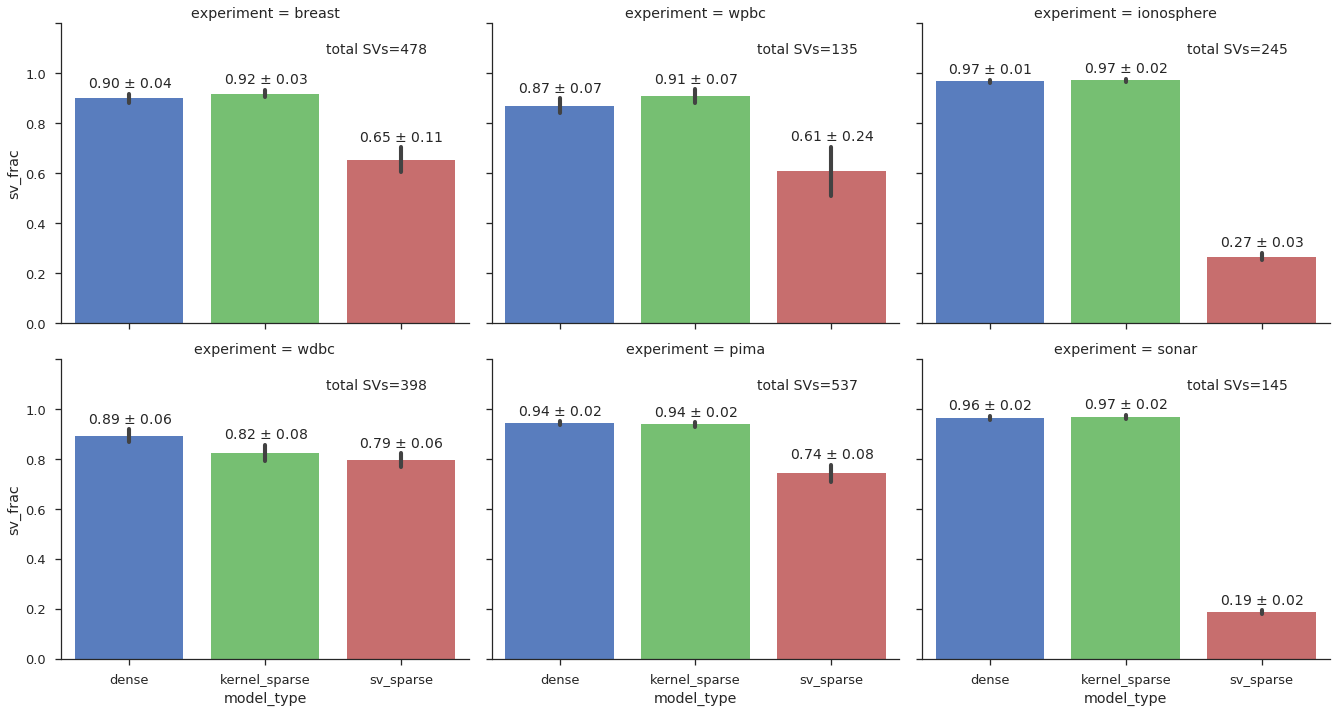

In [7]:
grid = sns.factorplot(x="model_type", y="sv_frac", col="experiment", data=df,
                      size=5, aspect=1.25, kind="bar", col_wrap=3, palette="muted")
for ax, (_, data) in zip(grid.axes, grid.facet_data()):
    ax.annotate(f"total SVs={data.total_sv.values[0]}", (0.65, 0.9), xycoords='axes fraction', size=14)
    ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
    ax.set_ylim(0, 1.2)
    
    for (group_name, group), l in zip(data.groupby('model_type'), ax.get_lines()):
        xy_data = l.get_xydata()[1]
        ax.annotate(f"{group.sv_frac.mean():0.2f} $\pm$ {group.sv_frac.std():0.2f}",
                     (xy_data[0] - 0.305, xy_data[1] + 0.025),
                     xycoords='data', size=14)

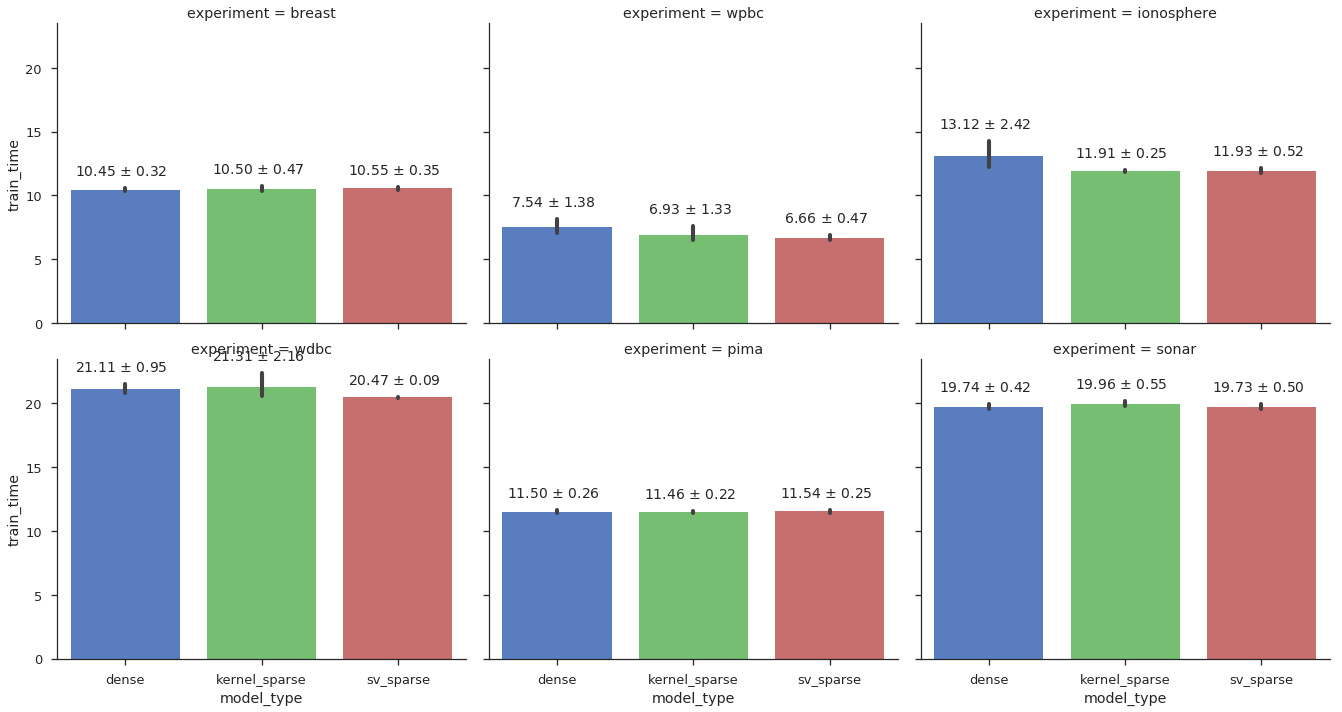

In [8]:
grid = sns.factorplot(x="model_type", y="train_time", col="experiment", data=df,
                      size=5, aspect=1.25, kind="bar", col_wrap=3, palette="muted")
for ax, (_, data) in zip(grid.axes, grid.facet_data()):
    for (group_name, group), l in zip(data.groupby('model_type'), ax.get_lines()):
        xy_data = l.get_xydata()[1]
        ax.annotate(f"{group.train_time.mean(): >5.2f} $\pm$ {group.train_time.std(): <5.2f}",
                     (xy_data[0] - 0.365, xy_data[1] + 1),
                     xycoords='data', size=14)


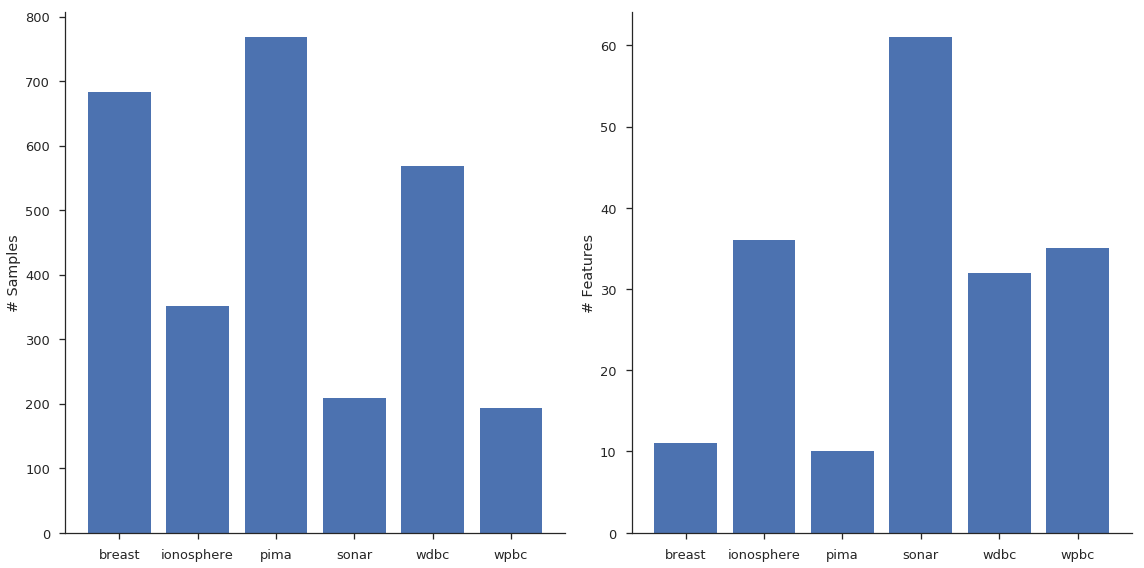

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.bar(datasets_df.name, datasets_df.samples)
ax2.bar(datasets_df.name, datasets_df.features)
ax1.set_ylabel('# Samples')
ax2.set_ylabel('# Features')
sns.despine()
plt.tight_layout()